In [98]:
# PYTHON IMPORTS
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
from random import randint

# LANDLAB COMPONENTS 
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
from landlab.components import PrecipitationDistribution

# SPACE COMPONENTS 
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

# LANDLAB UTILITIES 
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 
from landlab.utils.flow__distance import calculate_flow__distance

%matplotlib inline

retrieving the topography from ascii

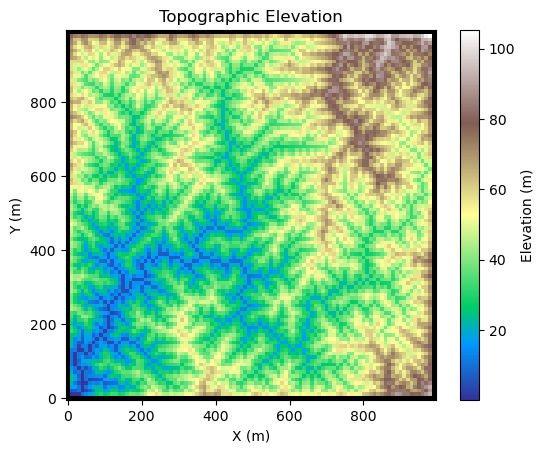

In [99]:
# GRID SPECS
ncols = 100
nrows = 100
cellsize = 10

# RETRIEVE TOPO FROM ASCII
#path_project = r"C:/Users/gsbir/Documents/EES_393/Export/" # add the path to the asc file    #this should access my H drive
topo_dem = "sample_topo2_topographic__elevation.txt" #the name of the ascii file
topo_path = topo_dem
topo_header = read_asc_header(open(topo_path, 'r'))
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0) #generating the new grid

# FIND OUTLET
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()
min_topo_ID = open_nodes[min_topo]
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
outlet_id = min_topo_ID

# HYDROLOGICALLY FILL THE DEM
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

# CLOSE BOUNDARIES
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)

# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

In [100]:
# PARAMETERS FOR SPACE
K_sed = 0.0001
K_sp = 0.001
K_br = 0.0001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#INSTANTIATING COMPONENTS 
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

fa = FlowAccumulator(mg, flow_director='D8') 

df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)

#RUNNING FSC FOR 1 YEAR TO IDENTIFY CHANNELS 
fa.run_one_step()
df.map_depressions()
fsc.run_one_step(1)

# SET UP CHANNEL PROFILER AND RUN 
profiler = ChannelProfiler(mg,number_of_watersheds=1,minimum_channel_threshold=0,main_channel_only=True)
profiler.run_one_step()
profiler.data_structure.keys() #is [101]
profiler.data_structure[101].keys()
profiler.data_structure[101][(101,9687)]["ids"] #produces array of id values for the channel

array([ 101,  102,  103,  204,  304,  404,  504,  604,  704,  803,  902,
       1002, 1102, 1202, 1303, 1304, 1205, 1306, 1406, 1507, 1608, 1709,
       1810, 1911, 2011, 2111, 2211, 2312, 2411, 2511, 2612, 2713, 2814,
       2915, 2916, 3017, 3117, 3218, 3219, 3220, 3321, 3421, 3520, 3620,
       3721, 3822, 3723, 3824, 3925, 3926, 3927, 3828, 3829, 3830, 3731,
       3632, 3633, 3734, 3735, 3836, 3837, 3838, 3739, 3740, 3741, 3642,
       3643, 3744, 3745, 3746, 3647, 3548, 3448, 3349, 3249, 3149, 3048,
       2947, 2846, 2747, 2648, 2549, 2448, 2447, 2346, 2247, 2147, 2048,
       1949, 1950, 1951, 2052, 1953, 1954, 1855, 1756, 1657, 1558, 1559,
       1460, 1361, 1462, 1563, 1664, 1764, 1864, 1965, 2065, 2165, 2266,
       2366, 2465, 2565, 2665, 2766, 2767, 2768, 2669, 2770, 2871, 2972,
       2973, 3074, 3175, 3076, 3077, 3178, 3279, 3180, 3281, 3382, 3481,
       3581, 3681, 3781, 3880, 3981, 4081, 4180, 4281, 4381, 4482, 4583,
       4584, 4585, 4686, 4687, 4588, 4589, 4690, 47

In [101]:
# ADDING SOIL FIELD
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

# ADDING BEDROCK FIELD
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']

# SETTING UP OUTLET ID 
mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
print(outlet_id)

# ADDING SURFACE WATER DEPTH
mg.add_zeros('surface_water__depth', at='node')

101


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [102]:
# INITIALIZE RAIN COMPONENTS 
of = OverlandFlow(mg, steep_slopes=True)
rain = SpatialPrecipitationDistribution(mg, number_of_years=1)

#storm_t = 1.5 #durration of a storm in hr
#interstorm_t = 8 #time between storms in hr
rain.total_time = 1 #this is for the rain.yield_storms (hr)
of_total_time = 3600 * 8#my own variable for how long overland flow runs in (s) -> 3600 s in 1 h

In [103]:
# RAIN AND OF PARAMETERS

total_yrs = 10 #total runtime of the loop (years)
i = 0

dont use stuff below!!!

#test of precip
precip = PrecipitationDistribution(mg, mean_storm_duration=8.5,
    mean_interstorm_duration=19.0, mean_storm_depth=3,
    total_t=46)
storm_dts = []
interstorm_dts = []
intensities = []
precip.seed_generator(seedval=1)
for (storm_dt, interstorm_dt) in precip.yield_storms():
    storm_dts.append(storm_dt)
    interstorm_dts.append(interstorm_dt)
    intensities.append(mg.at_grid['rainfall__flux'])
    plt.figure()# plot up this storm
    imshow_grid(mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (mm/h)')
    plt.show()
len(storm_dts) == 4  # 4 storms in the simulation

In [105]:
# RUN OVERLAND FLOW AND RAIN TOGETHER

while(i < total_yrs):
    # 1 season = 90 days = 2160 hrs = 7776000 s
    
    
    
    
    
    i+=1 #iterate 



0.014683657999
1


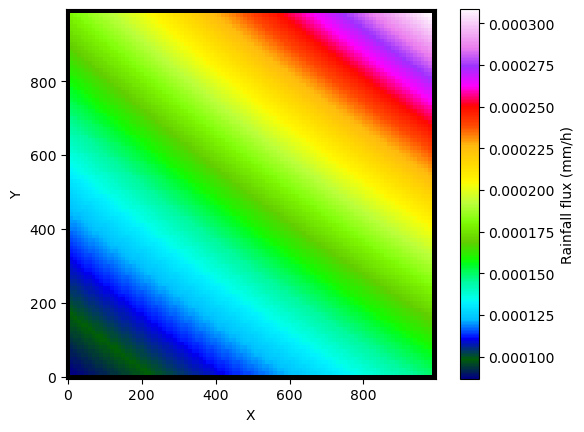

3.14555001763
1


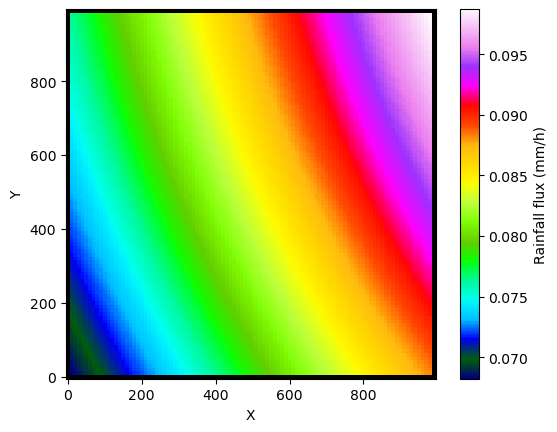

In [106]:

np.random.seed(randint(0, 100)) 

# get the storm simulator to provide a storm

storm_time_data = []
interstorm_time_data = []
storm_amt_data = []
x = 1 #to keep track of each iteration of loop


#this is running for a year
for (storm_t, interstorm_t) in rain.yield_storms(style="whole_year"):  # storm lengths in hrs
    
    storm_time_data.append(storm_t)
    interstorm_time_data.append(interstorm_t*.041)
    storm_amt_data.append(x)
    mg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    mg.at_node['rainfall__flux'] *= 2.0  # to make the storm heavier
    print(rain.median_total_rainfall_this_year)
    print(rain.total_time)
    plt.figure()# plot up this storm
    imshow_grid(mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (mm/h)')
    plt.show()
    x+=1